In [1]:
using LinearAlgebra
using Plots
using NLsolve
using Optim
using NonlinearSolve 
using Roots
using Distributed

# Spectrum and Eigenfunctions

In [2]:
function ZeroMat(N::Int)
    return zeros((N,N))
end

function TrapHamiltonian(L::Int, t::Float64, v::Float64, g::Float64)
    """
    Writes matrix representation of spinless fermion Hamiltonian on a lattice with L sites
    and a quadratic trapping potential of strength g. 

    INPUTS
    L: number of lattice sites
    t: hopping parameter
    v: constant on-site potential
    g: trapping potential strength

    OUTPUT
    H: LxL matrix representation of non-interacting fermion Hamiltonian
    """
    H = ZeroMat(L)
    for i in range(1,L)
        H[i,i] = v + g*(i-L/2)*(i-L/2)
    end
    for i in range(1,L-1)
        H[i,i+1] = -t
        H[i+1,i] = -t
    end
    return H
end

function BraggHamiltonian(L::Int, t::Float64, v::Float64, g::Float64, m::Int, q::Float64)
    """
    Writes matrix representation of spinless fermion Hamiltonian on a lattice with L sites
    and a quadratic trapping potential of strength g. 

    INPUTS
    L: number of lattice sites
    t: hopping parameter
    v: constant on-site potential
    g: trapping potential strength

    OUTPUT
    H: LxL matrix representation of non-interacting fermion Hamiltonian
    """
    H = ZeroMat(L)
    for i in range(1,L)
        H[i,i] = v + g*(i-L/2)*(i-L/2) + m *cos.(q*(i-L/2)).^2
    end
    for i in range(1,L-1)
        H[i,i+1] = -t
        H[i+1,i] = -t
    end
    return H
end

function FreeHamOBC(L::Int, t::Float64, v::Float64)
    """
    Writes matrix representation of spinless fermion Hamiltonian on a lattice with L sites
    and a quadratic trapping potential of strength g. 

    INPUTS
    L: number of lattice sites
    t: hopping parameter
    v: constant on-site potential
    g: trapping potential strength

    OUTPUT
    H: LxL matrix representation of non-interacting fermion Hamiltonian
    """
    H = ZeroMat(L)
    for i in range(1,L)
        H[i,i] = v 
    end
    for i in range(1,L-1)
        H[i,i+1] = -t
        H[i+1,i] = -t
    end
    return H
end

FreeHamOBC (generic function with 1 method)

In [ ]:
eigenvalues::Vector{Float64} = eigvals(TrapHamiltonian(1000,1.0,0.1,1e-5))
eigenvectors = eigvecs(TrapHamiltonian(1000,1.0,0.1,1e-5))
# post_eigval = eigvals(FreeHamOBC(1000,1.0,0.1))
# post_eigvec = transpose(eigvecs(FreeHamOBC(1000,1.0,0.1)))
sites = range(0,999,length=1000)
plot(sites,abs.(eigenvectors[:,31]).^2)
# plot(sites,post_eigvec[11,:])
typeof(eigvecs(TrapHamiltonian(1000,1.0,0.1,1e-5)))

ErrorException: cannot set type for global Main.eigenvectors. It already has a value or is already set to a different type.

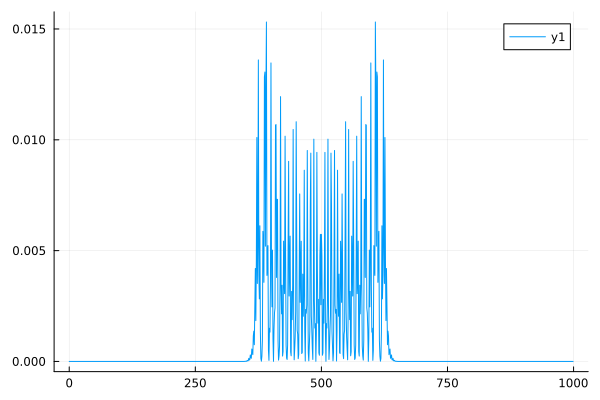

In [48]:
eigenvalues = eigvals(BraggHamiltonian(1000,1.0,0.1,1e-5,10,pi/2))
eigenvectors = transpose(eigvecs(BraggHamiltonian(1000,1.0,0.1,1e-5,2,1.0)))
# post_eigval = eigvals(FreeHamOBC(1000,1.0,0.1))
# post_eigvec = transpose(eigvecs(FreeHamOBC(1000,1.0,0.1)))
sites = range(0,999,length=1000)
plot(sites,abs.(eigenvectors[31,:]).^2)
# plot(sites,post_eigvec[11,:])

# Finite temperature

In [ ]:
# function PartitionFunc(L, beta, E, mu)
#     """
#     """
#     return ones(L) + exp.(-beta*(E-mu*ones(L)))
# end

function NCorrFiniteT(L::Int, beta::Any, U::Any, E::Vector{Float64}, mu::Any)
    """
    Calculate N-body correlation function in equilibrium at finite temperature

    INPUTS
    L: number of sites
    beta: inverse temperature
    U: matrix of eigenvectors
    E: vector of eigenvalues
    mu: chemical potential

    OUTPUT
    C: matrix of one-body correlations
    """
    identity = Matrix(1.0I,L,L)
    D = inv(identity + Diagonal(exp.(-beta * (E - mu*ones(L)))))
    Dprime = transpose(U) * D * U
    return identity - Dprime
end

function GetChemicalPotential(L::Int, beta::Any, N::Int, U::Any, E::Vector{Float64})
    """
    Get chemical potential provided N particles at temperature T

    INPUTS
    L: number of lattice sites; int
    N: number of particles; int
    beta: inverse temperature; float
    U: matrix of eigenvectors; matrix of floats
    E: list of eigenvalues; list of floats

    OUTPUT
    mu: chemical potental; float
    """
    func(mu) = sum(diag(NCorrFiniteT(L,beta,U,E,mu))) - N
    mu_guess = maximum(E[1:N])
    sol = find_zero(func,mu_guess)
    return sol
end

function pij(t::Any,beta::Any,mu::Any,L::Int,U1::Any,U2::Any,E1::Vector{Float64},E2::Vector{Float64})
    """
    Calculate equal-time one-body density matrix at finite T and non-zero time after a quench.
    
    INPUTS
    t: time; units of hbar/J
    beta: inverse temperature; units of 1/J
    mu: chemical potential; units of J
    L: lattice sites; dimensionless
    U1: matrix of eigenvectors of pre-quench Hamiltonian
    U2: matrix of eigenvectors of post-quench Hamiltonian
    E1: vector of eigenvalues of pre-quench Hamiltonian
    E2: vector of eigenvalues of post-quench Hamiltonian

    OUTPUT
    One-body correlation density matrix.
    """
    C0 = NCorrFiniteT(L,beta,U1,E1,mu)
    D = Diagonal(exp.(complex(0,t)*E2))
    D1 = D * U2
    D2 = transpose(conj(U2)) * D1
    C1 = C0 * D2
    C2 = conj(D2) * C1
    return C2
end

function nkt(k::Any, L::Int, beta::Int, t::Any, P::Any, sites::Any)
    """
    Calculate momentum distribution function at finite T and non-zero time after a quench.
    
    INPUTS
    k: quasi-momentum; units of 1/a
    L: lattice sites; dimensionless
    beta: inverse temperature; units of 1/J
    t: time; units of hbar/J
    U1: matrix of eigenvectors of pre-quench Hamiltonian
    U2: matrix of eigenvectors of post-quench Hamiltonian
    E1: vector of eigenvalues of pre-quench Hamiltonian
    E2: vector of eigenvalues of post-quench Hamiltonian
    mu: chemical potential; units of J

    OUTPUT
    Momentum distribution function
    """
    A = exp.(sites*complex(0,K))
    eik = A * transpose(conj(A)) / L
    return sum(eik .* P)
end

nkt (generic function with 2 methods)

In [87]:
chem = GetChemicalPotential(length,temp,31,eigenvectors,eigenvalues)
sites = range(0,999,length=1000)
Ptest = pij(time,temp,chem,length,eigenvectors,post_eigvec,eigenvalues,post_eigval)
@time nkt(1,1000,100,1,Ptest,sites)

  0.107576 seconds (36.63 k allocations: 47.570 MiB, 2.93% gc time, 87.07% compilation time)


1.3962426282529858e-15 + 2.0264827087848553e-18im

### Trap -> free expansion; L=1000; OBC

In [74]:
eigenvalues = eigvals(TrapHamiltonian(1000,1.0,0.1,1e-5))
eigenvectors = transpose(eigvecs(TrapHamiltonian(1000,1.0,0.1,1e-5)))
post_eigval = eigvals(FreeHamOBC(1000,1.0,0.1))
post_eigvec = transpose(eigvecs(FreeHamOBC(1000,1.0,0.1)))

Np = 31
length = 1000
chem = GetChemicalPotential(1000,100,31,eigenvectors,eigenvalues)
sites = range(0,999,length=1000)

function n(t,temp)
    """
    Local number density as a function of time t and temperature temp. 
    """
    chempot = GetChemicalPotential(length,temp,Np,eigenvectors,eigenvalues)
    return real(diag(pij(t,temp,chempot,length,eigenvectors,post_eigvec,eigenvalues,post_eigval)))
end

n (generic function with 1 method)

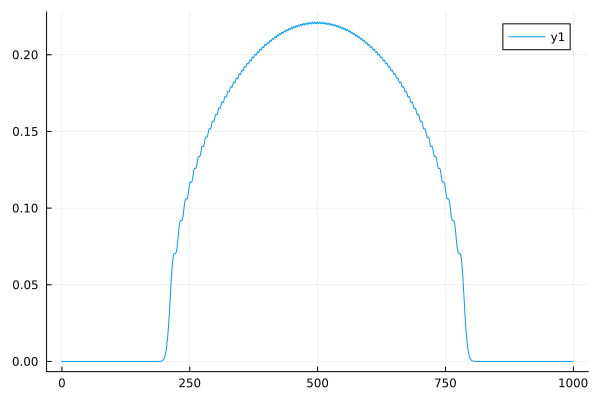

In [ ]:
plot(sites,n(100,100))

In [75]:
temp = 100
length = 1000
time = 0
chem = GetChemicalPotential(length,temp,31,eigenvectors,eigenvalues)
Ptest = real(pij(time,temp,chem,length,eigenvectors,post_eigvec,eigenvalues,post_eigval))
function mdf(k)
    return real(nkt(k,length,temp,time,Ptest))
end

map((k)->real(nkt(k,1000,100,1,Ptest)), range(0,pi,101))

101-element Vector{Float64}:
  0.27887145177743966
  0.01816282812681895
 -0.011353635879466875
  0.00452557998453349
 -0.00020987040018470083
 -0.0010499014654328108
  0.0004211729348460292
  0.0001926836833728808
 -4.2528880462728235e-5
 -4.536833914859555e-5
  ⋮
  1.8899207564659576e-15
 -2.7981735591583363e-15
  4.8198342169741135e-15
 -1.6718671805266832e-15
 -1.9384000605811092e-16
  1.132956464182378e-15
  5.067978410717345e-16
  1.0621560162605258e-15
  2.1499375608613395e-16

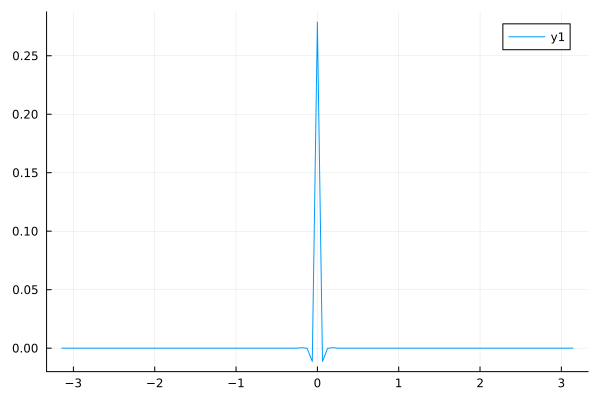

In [76]:
plot(range(-pi,pi,101),map((k)->real(nkt(k,1000,100,10,Ptest)), range(-pi,pi,101)))